In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
from numpy.random import default_rng
import numba as nb
from numba import vectorize,jit,prange,objmode

In [2]:
rng = default_rng()

In [3]:
error = 1e-10 #because machine error is *really* important when working with linalg

In [4]:
#@jit(fastmath=True,parallel=True)
def normalize(v):
    l = np.linalg.norm(v)
    if l < error:
        print("Something has gone terribly wrong with "+str(v))
        return v
    return v/l

Questions for next version:
* Make precise:
    * Why probability 1? Give intuition and what measure 0 set works
    * Say what $x_n, p_n, v_n$ are, give picture
    * Conjecture 4.1: Provide evidence and convince the reader that, for irrational starting direction 
        * Get some random [convex polygons](https://cglab.ca/~sander/misc/ConvexGeneration/convex.html) and see if that works
    * Check conj 4.2 for irregular triangles
* Density of paths:
    * How to measure?
        * Maybe try making circles and finding the largest radius $\epsilon$ s.t. $B_\epsilon \cap L =\emptyset$ (for $L$ is the set of points in the lines)
    * How dense are random paths on 7-gons? Show with 1000 bounces
    * Are there protected regions in small $n$ $n$-gons? If so, how?

### Defining shapes
In general we will define a discrete shape to be an array of pairs of points which represent the lines between them.

In [85]:
#@jit(fastmath=True,parallel=True)
def polar_poly(r,n):
    r = np.vectorize(r)
    theta = 2*np.pi/n
    angles = np.array([x*theta for x in prange(n)])
    p0s = np.vstack((r(angles)*np.cos(angles),r(angles)*np.sin(angles))).T
    p1s = np.array([p0s[1]])
    #for i,_ in enumerate(p0s):
    #    p1s = np.append(p1s,[p0s[(i+1)%n]],axis=0)
    #p1s = p1s[1:]
    p1s = np.array(list(map(lambda i: p0s[(i+1)%n],range(n))))
    return (np.vstack((p0s,p1s)).T)

In [86]:
#@jit(fastmath=True,parallel=True,forceobj=True)
def ngon(n):
    return polar_poly(lambda t: 1,n)

[ 1.0000000e+00  6.1232340e-17 -1.0000000e+00 -1.8369702e-16
  6.1232340e-17 -1.0000000e+00 -1.8369702e-16  1.0000000e+00]
[[ 1.0000000e+00  6.1232340e-17 -1.0000000e+00 -1.8369702e-16
   6.1232340e-17 -1.0000000e+00 -1.8369702e-16  1.0000000e+00]
 [ 0.0000000e+00  1.0000000e+00  1.2246468e-16 -1.0000000e+00
   1.0000000e+00  1.2246468e-16 -1.0000000e+00  0.0000000e+00]]


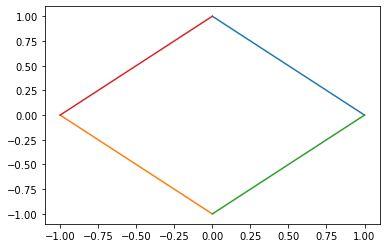

In [87]:
sq = ngon(4)
print(sq[0])
print(sq)
plt.plot(*sq.T)

In [88]:
#@jit(fastmath=True)
def atanp(p1):
        return np.arctan2(p1[1],p1[0])
# Adapted from Sander Verdonschot's code from https://cglab.ca/~sander/misc/ConvexGeneration/convex.html
#@jit('double[:,:,::1](int32)',fastmath=True,parallel=True,forceobj=True)
def rand_convex(n):
    xs = np.array([])
    ys = np.array([])
    
    xs = np.sort(rng.random(n)*2-1)
    ys = np.sort(rng.random(n)*2-1)

    xmin = np.min(xs)
    xmax = np.max(xs)
    ymin = np.min(ys)
    ymax = np.max(ys)
    
    xv = np.array([])
    yv = np.array([])
    lastTop = xmin
    lastBot = xmin
    for x in xs:
        if rng.choice([True,False]):
            xv = np.append(xv,x-lastTop)
            lastTop = x
        else:
            xv = np.append(xv,lastBot-x)
            lastBot = x
    xv = np.append(xv,xmax-lastTop)
    xv = np.append(xv,lastBot-xmax)
    
    lastTop = ymin
    lastBot = ymin
    for y in ys:
        if rng.choice([True,False]):
            yv = np.append(yv,y-lastTop)
            lastTop = y
        else:
            yv = np.append(yv,lastBot-y)
            lastBot = y
    yv = np.append(yv,ymax-lastTop)
    yv = np.append(yv,lastBot-ymax)
    
    rng.shuffle(yv)
    
    vec = np.vstack((xv,yv)).T
    vec = sorted(vec,key=atanp)
    
    minx, miny = -1,-1
    p0 = np.array([0,0])
    p = np.array([0,0])
    p0s = np.array([p0])
    
    for v in vec[:-1]:
        p = p+v
        minx = min(minx,p[0])
        miny = min(miny,p[1])
    
    off = np.array([xmin - minx,ymin - miny])
    
    for v in vec[:-1]:
        p0 = p0+v+off
        p0s = np.append(p0s,[p0],axis=0)
    p1s = np.array([p0s[1]])
    for i in prange(n-1):
        i2 = (i+2)%n
        p1s = np.append(p1s,[p0s[i2]],axis=0)
    return np.array(list(zip(p0s,p1s)))

In [89]:
nb.typeof(rand_convex(4)[0])

array(float64, 2d, C)

In [90]:
#@jit(fastmath=True,parallel=True)
def circle_arcs(n):
    @vectorize
    def f(t):
        return np.array([np.cos(t),np.sin(t)])
    fs = []
    ns = []
    tbounds = []
    for i in prange(n):
        fs.append(f)
        ns.append(f)
        tbounds.append((2*np.pi/i,2*np.pi/(i+1)))
    return (fs,ns,tbound)

In [91]:
#@jit(fastmath=True,parallel=True,forceobj=True)
def polar_curve(r,rprime):
    rhat = lambda t: np.array([np.cos(t),np.sin(t)])
    that = lambda t: rhat(t+np.pi/2)
    f = lambda t: r(t)*np.array([np.cos(t),np.sin(t)])
    n = lambda t: -r(t)*rhat(t)+rprime(t)*that(t)
    tbound = (0,2*np.pi)
    return ([f],[n],[tbound])

General Hit Algorithms

In [92]:
#@jit(fastmath=True,parallel=True)
def line_hit(x,v,p0,p1):
    dp = p0-p1#np.subtract(p0,p1)
    a = np.vstack((v,dp)).T
    b = p0-x#np.subtract(p0,x)
    t = np.linalg.solve(a,b)
    nx = x+t[0]*v #np.add(x,np.multiply(t[1],v))
    p = p0-t[1]*dp#np.add(p0,np.multiply(t[0],dp))
    if t[1] < 1 and t[1] > 0 and t[0] > 0 and np.linalg.norm(p-nx) < error:
        n = np.array([-dp[1],dp[0]])
        return True, (p,n,(x,v,t[0]))
    else:
        return False, ()

In [93]:
#@jit(fastmath=True,parallel=True)
def curve_hit(x,v,f,n,tbound):
    def g(st):
        return (x+v*st[0])-f(st[1])
    hit,_,_,i,m = fsolve[f,[1,0.5*tbound[0]+0.5*tbound[1]]]
    if i == 1:
        r = normalize(n(hit[1]))
        p = x+v*hit[0]
        return True, (p,r,(x,v,st[1]))
    return False, ()

Filtering specific hits of piecewise curves/shapes

In [94]:
#@jit(fastmath=True,parallel=True,forceobj=True)
def general_hit(hits):
    crossings = np.array([])
    for hit in hits:
        if hit[0]:
            crossings = np.append(crossings,[hit[1],hit[2]])
    #if crossings == []:
        #print('oh no')
        #print(hits)
    def x022(x):
        return x[0][2][2]
    cross = np.sort(crossings,key=x022)[0]
    p = cross[0][0]
    n = cross[0][1]
    s = cross[1]
    return p, n, s

In [95]:
def polygon_hit(ps):
    print(ps)
    #@jit(fastmath=True,parallel=True,forceobj=True)
    def hit(x,v):
        hits = list(map(lambda p: line_hit(x,v,*p[1])+(p[0],),enumerate(ps))) #append i to the side
        return general_hit(hits)
    return hit

In [96]:
def piecewise_smooth(fs,ns,tbounds):
    #@jit(fastmath=True,parallel=True)
    def hit(x,v):
        def mapper(ifnt):
            return curve_hit(x,v,ifnt[1],ifnt[2],ifnt[3])+(ifnt[0],)
        hits = np.array(list(map(mapper,enumerate(zip(fs,ns,tbounds)))))
        return general_hit(hits)
    return hit

Special Cases

In [97]:
#@jit(fastmath=True,parallel=True)
def circle_hit(x,v):
    b = np.dot(v,x)
    c = np.linalg.norm(x)**2 -1
    ts = -b+np.array([1,-1])*np.sqrt(b**2 - c)
    t = np.max(ts)#np.min(ts[np.all(np.greater(ts,[0,0]))])
    p = x+t*v
    n = -p
    return p, n, np.arctan2(x[1],x[0])

Bounce algorithm

In [98]:
#@jit(fastmath=True,parallel=True)
def bounce(v,n):
    n = normalize(n)
    return v-2*np.dot(n,v)*n#np.subtract(v,np.multiply(2*np.dot(n,v),n))

Simulation of many bounces

In [99]:
#@jit(fastmath=True,parallel=True)
def sim(hitFunc,x,v,depth):
    lines = [(x,v,-1)]
    for _ in prange(depth):
        x, n, s = hitFunc(x,v)
        v = bounce(v,n)
        x = x+error*v#np.add(x,np.multiply(1e-12,v))
        lines = lines + [(x,v,s)]
    return lines

Random Start Info

In [100]:
#@jit('double[:](double)',fastmath=True,parallel=True,forceobj=True)
def randx(rad):
    r = 0
    r = rng.random()*rad
    theta = 2*np.pi*rng.random()
    x = np.multiply(r,np.array([np.cos(theta),np.sin(theta)]))
    return x
#@jit('double[:]()',fastmath=True,parallel=True,forceobj=True)
def randv():
    vtheta = 0
    vtheta = 2*np.pi*rng.random()
    v = np.array([np.cos(vtheta),np.sin(vtheta)])
    return v

Get data for plotting

In [101]:
@vectorize
def snd(x):
    return x[2]
#@jit(fastmath=True,parallel=True)
def side_chance(sim_result,mod=0):
    s = snd(sim_result[1:])
    if mod != 0:
        s = np.mod(s,mod)
    uniques = np.unique(s)
    @vectorize
    def sums(u):
        return np.sum(1 for side in s if side == u)
    counts = sums(uniques)
    counts = normalize(counts)
    return uniques,counts

Length probability sims

In [102]:
def sl(q):
    return np.linalg.norm(q[1]-q[0])
sidelen = np.vectorize(sl,signature='(2,2)->()')
#@jit(fastmath=True,parallel=True,nopython=False)
def lenprob(depth,sides,trials):
    tries=1000
    length = np.array([])
    prob = np.array([])
    theta = np.array([])
    
    for n in prange(sides-3):
        #print("Got to {} sides".format(n+3))
        for k in prange(trials):
            shape = 10*rand_convex(n+3)
            hit = polygon_hit(shape)
            sidelengths = sidelen(shape)
            t = 0
            ls = None
            while t < tries:
                t += 1
                v = randv()
                try:
                    ls = sim(hit,randx(1),v,depth)
                    t = tries+1
                except:
                    continue
                print('sim succeeded')
                us,cs = side_chance(ls)
                ncs = cs/np.sum(sidelengths)
                length = np.append(length,sidelengths[us])
                prob = np.append(prob,ncs)
                theta = np.append(theta,np.arctan2(v[1],v[0]))
                print("bounce!")
    return length, prob, theta

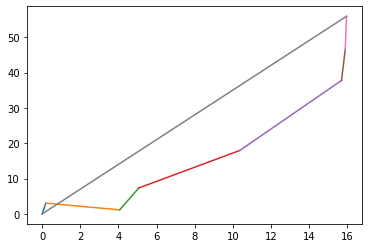

In [103]:
plt.plot(*(10*rand_convex(8)).T)

In [104]:
#from mpl_toolkits.mplot3d import Axes3D
#fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
#l,p,a = lenprob(5000,5,10000)
#print(l,p,a)
#plt.plot(l,p,'k.')
#plt.show()
#ax.scatter(l,p,a)
#plt.show()

Specific Square Sims

In [105]:
sq = ngon(4)
sqhit = polygon_hit(sq)
ls = sim(sqhit,np.array([0,0.5]),np.array([np.sqrt(2)/2,1]),1000)
plt.plot(*sq.T)
xs = list(map(lambda x: x[0][0], ls))
ys = list(map(lambda x: x[0][1], ls))
plt.plot(xs,ys)
x,v,_ = ls[-1]
plt.quiver(*x,*v)
ax = plt.gca()
ax.set_aspect(1)
plt.savefig('ngonorbit.png')
plt.show()

[[ 1.0000000e+00  6.1232340e-17 -1.0000000e+00 -1.8369702e-16
   6.1232340e-17 -1.0000000e+00 -1.8369702e-16  1.0000000e+00]
 [ 0.0000000e+00  1.0000000e+00  1.2246468e-16 -1.0000000e+00
   1.0000000e+00  1.2246468e-16 -1.0000000e+00  0.0000000e+00]]


TypeError: line_hit() takes 4 positional arguments but 10 were given

In [ ]:
ss = list(map(lambda x: x[2]%2,ls[1:]))
#print(ss)
#ax = plt.gca()
#ax.hist(ss,bins=2*sides)
us,cs = side_chance(ls,mod=2)
plt.bar(us,cs)

Specifically Circular Sims

In [ ]:
deg = 30
theta = np.pi/2-(np.pi/180)*deg #<- Edit this!
ls = sim(circle_hit,np.array([0,1]),np.array([np.cos(theta),np.sin(theta)]),1000)
xs = list(map(lambda x: x[0][0], ls))
ys = list(map(lambda x: x[0][1], ls))
#print(xs)
plt.plot(xs,ys)
print(ls[-1])
x,v,_ = ls[-1]
plt.quiver(*x,*v)
draw_circle = plt.Circle((0, 0), 1,fill=False)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.gcf().gca().add_artist(draw_circle)
plt.gca().set_aspect(1)
plt.savefig("{}deg.png".format(deg))
plt.show()

In [ ]:
ss = list(map(lambda x: x[2],ls[1:]))
#print(ss) #<- Side sequence
#ax = plt.gca()
#ax.hist(ss,bins=bounces)
us,cs = side_chance(ls)
plt.bar(us,cs,width=0.05)

Discrete Cardiod Sims

In [ ]:
shape = polar_poly(lambda t: 1+np.cos(t),6)
shapehit = polygon_hit(shape)
ls = sim(shapehit,randx(0.5)+np.array([0.75,0]),randv(),10000)
#ls = sim(shapehit,np.array([0.,0.]),np.array([0.,1.]),100)
plt.plot(*shape.T)
xs = list(map(lambda x: x[0][0], ls))
ys = list(map(lambda x: x[0][1], ls))
plt.plot(xs,ys)
x,v,_ = ls[-1]
plt.quiver(*x,*v)
ax = plt.gca()
ax.set_aspect(1)
plt.savefig('6cardiodrand.png')
plt.show()

In [ ]:
ss = list(map(lambda x: x[2],ls[1:]))
#print(ss)
#ax = plt.gca()
#ax.hist(ss,bins=bounces)
sidelengths = np.array(list(map(lambda q: np.linalg.norm(q[1]-q[0]),shape)))
print(sidelengths)
us,cs = side_chance(ls)
print(sum(cs))
ncs = cs#/sum(sidelengths)
plt.bar(us,ncs,width=0.75)
plt.plot(us,sidelengths[us]/sum(sidelengths),'rx')
plt.savefig("6normcardiodsidesplot.png")

In [ ]:
(fs,ns,ts) = polar_curve(lambda t: 1+np.cos(t),lambda t: -np.sin(t))
hit = piecewise_smooth(fs,ns,ts)
ls = sim(hit,randx(0.5)+np.array([0.75,0]),randv(),1000)
ts = np.linspace(0,2*np.pi)
xs = (1+np.cos(ts))*np.cos(ts)
ys = (1+np.cos(ts))*np.sin(ts)
plt.plot(xs,ys)
#xs = list(map(lambda x: x[0][0], ls))
#ys = list(map(lambda x: x[0][1], ls))
#plt.plot(xs,ys)
#x,v,_ = ls[-1]
#plt.quiver(*x,*v)
ax = plt.gca()
ax.set_aspect(1)

Setting up shapes etc.

In [ ]:
sides = 110
bounces = 1000
ng = ngon(sides)
nghit = polygon_hit(ng)

Random Circle & N-Gon

In [ ]:
ls = sim(nghit,randx(np.cos(np.pi/sides)),randv(),bounces)
plt.plot(*ng.T)
xs = list(map(lambda x: x[0][0], ls))
ys = list(map(lambda x: x[0][1], ls))
plt.plot(xs,ys)
x,v,_ = ls[-1]
plt.quiver(*x,*v)
ax = plt.gca()
ax.set_aspect(1)
plt.savefig('ngonirrational2.png')
plt.show()

In [ ]:
ss = list(map(lambda x: x[2],ls[1:]))
#print(ss)
#ax = plt.gca()
#ax.hist(ss,bins=2*sides)
us,cs = side_chance(ls)
plt.bar(us,cs)
plt.savefig('100.png')

In [ ]:
ls = sim(circle_hit,randx(0.9),randv(),bounces)
xs = list(map(lambda x: x[0][0], ls))
ys = list(map(lambda x: x[0][1], ls))
plt.plot(xs,ys)
print(ls[-1])
x,v,_ = ls[-1]
plt.quiver(*x,*v)
draw_circle = plt.Circle((0, 0), 1,fill=False)
plt.gcf().gca().add_artist(draw_circle)
plt.gca().set_aspect(1)
plt.show()

In [ ]:
ss = list(map(lambda x: x[2],ls[1:]))
#print(ss)
#ax = plt.gca()
#ax.hist(ss,bins=bounces)
us,cs = side_chance(ls)
plt.bar(us,cs,width=0.05)